### Third Notebook : Keras Embedding + BiLSTM + Attention 

In [3]:
# Importing Libraries
import re
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import backend as K
from keras import layers

#### Utility Functions 

In [4]:
def processing(data):
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    y = pd.get_dummies(data['Basic']).values

    return data,y

In [6]:
data = pd.read_csv('../Datasets/MRDA/mrda_data/full_set.txt', sep='|')
data.columns=['Speaker','Utterances','Basic','General','Full']
MAX_PADDING = 100
def x_value(data):
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(data['Utterances'].values)
    x = tokenizer.texts_to_sequences(data['Utterances'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)
    
    return x

In [7]:
train_data = pd.read_csv('../Datasets/MRDA/mrda_data/full_set.txt', sep='|')
train_data.columns=['Speaker','Utterances','Basic','General','Full']
train_data,y_train = processing(train_data)
x_train = x_value(train_data)

val_data = pd.read_csv('../Datasets/MRDA/mrda_data/train_set.txt', sep='|')
val_data.columns=['Speaker','Utterances','Basic','General','Full']
val_data,y_val = processing(val_data)
x_val = x_value(val_data)

test_data = pd.read_csv('../Datasets/MRDA/mrda_data/test_set.txt', sep='|')
test_data.columns=['Speaker','Utterances','Basic','General','Full']
test_data,y_test = processed_data(test_data)
x_test = x_value(test_data)

### Attention Mechanism Coding  

In [10]:
from keras.layers import Layer
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [11]:
inputs1=Input(shape=(100,))

x1=Embedding(input_dim=5000,
             output_dim=300,
             input_length=100,
             embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)

x1=Bidirectional(LSTM(units=20,
                      dropout=0.3,
                      recurrent_dropout=0.2,
                      return_sequences = True))(x1)

x1=attention()(x1)

output=Dense(5,activation='softmax')(x1) 

model=keras.Model(inputs1,output)

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          1500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 40)           51360     
_________________________________________________________________
attention (attention)        (None, 40)                140       
_________________________________________________________________
dense (Dense)                (None, 5)                 205       
Total params: 1,551,705
Trainable params: 1,551,705
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, dpi=90)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [10]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=1, 
                                               verbose=1)

hist = model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val))

Epoch 1/100
2346/2346 [==============================] - 323s 136ms/step - loss: 1.0376 - accuracy: 0.6264 - val_loss: 1.0162 - val_accuracy: 0.5821
Epoch 2/100
2346/2346 [==============================] - 332s 141ms/step - loss: 0.9325 - accuracy: 0.6508 - val_loss: 0.9549 - val_accuracy: 0.6183
Epoch 3/100
2346/2346 [==============================] - 332s 141ms/step - loss: 0.8390 - accuracy: 0.7038 - val_loss: 0.7825 - val_accuracy: 0.7527
Epoch 4/100
2346/2346 [==============================] - 332s 142ms/step - loss: 0.7182 - accuracy: 0.7668 - val_loss: 0.7512 - val_accuracy: 0.7514
Epoch 5/100
2346/2346 [==============================] - 333s 142ms/step - loss: 0.6814 - accuracy: 0.7772 - val_loss: 0.7281 - val_accuracy: 0.7593
Epoch 6/100
2346/2346 [==============================] - 334s 142ms/step - loss: 0.6657 - accuracy: 0.7826 - val_loss: 0.7253 - val_accuracy: 0.7627
Epoch 7/100
2346/2346 [==============================] - 335s 143ms/step - loss: 0.6559 - accuracy: 0.7850

In [11]:
model.evaluate(x_test, y_test)

522/522 [==============================] - 10s 19ms/step - loss: 0.6485 - accuracy: 0.7845


[0.648459792137146, 0.7845039367675781]

In [15]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 100


def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

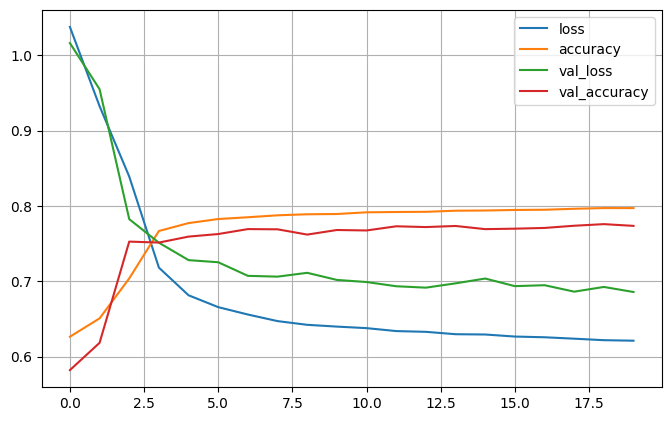

In [16]:
plot(hist)

In [1]:
print('The model accuracy is : 0.78')

The model accuracy is : 0.78
